# Adding noise to a scheduled circuit

- *Author*: Christopher J Wood
- *Last Updated*: May 11, 2020
- *Requires*: Itoko's Scheduled Circuit terra branch https://github.com/itoko/qiskit-sdk-py/tree/mvp-circuit-with-duration

In [1]:
from qiskit import transpile
from qiskit.converters import circuit_to_dag, dag_to_circuit
from qiskit.transpiler.passes.scheduling.asap import ASAPSchedule
from qiskit.transpiler.passes.scheduling.alap import ALAPSchedule
from qiskit.transpiler.passes.scheduling.alap import ALAPSchedule
from qiskit.transpiler.passes.scheduling.timestepsasap import TimestepsASAPSchedule

import qiskit.quantum_info as qi
from qiskit.providers.aer.noise import thermal_relaxation_error
from qiskit.extensions import RZZGate

import itertools as it
import numpy as np
import seaborn as sns
sns.set()

def schedule(circuit, backend):
    """Schedule a circuit."""
    # TODO: Allow specifying gate times without having to pass in a backend    
    dag = circuit_to_dag(circuit)
    dag_with_delays = ASAPSchedule(backend).run(dag)
    scheduled = dag_to_circuit(dag_with_delays)
    return scheduled

def timestep_schedule(circuit, backend):
    """Schedule a circuit with time-steps added"""
    dag = circuit_to_dag(circuit)
    dag_with_delays = TimestepsASAPSchedule(backend).run(dag)
    scheduled = dag_to_circuit(dag_with_delays)
    return scheduled

def insert_noise(scheduled_circuit, dt=None, t1=None, t2=None, zz_map=None):
    """Insert thermal relaxation and cross-talk noise into a scheduled circuit."""
    
    # This replaces all noisy instructions in circuit with a
    # Kraus instruction for simulation
    
    # Create empty circuit
    noise_circ = QuantumCircuit(*scheduled_circuit.qregs, *scheduled_circuit.cregs)
    allowed_qubits = set(range(noise_circ.num_qubits))

    for instr, qubits, clbits in scheduled_circuit.data:
        
        # Check if time step instruction
        # TODO: check via isinstance instead of name
        if instr.name == 'timestep':
            # Add cross-talk
            # TODO: handle unit conversion from zz to time unites
            if zz_map is not None:
                for w_zz, qubits in zz_map:
                    if allowed_qubits.union(qubits) == allowed_qubits:
                        t = instr.params[0] * dt
                        if t > 0 and abs(w_zz) > 0:
                            gate = RZZGate(w_zz * t)
                            gate.label = 'ZZ(noise)'
                            noise_circ.append(gate, qubits)
        else:
            # Add relaxation errors
            t = instr.duration * dt
            if t > 0:
                try:
                    iqubits = [i.index for i in qubits]
                    errors = [thermal_relaxation_error(t1[i], t2[i], t) for i in iqubits]

                    # Combine errors with gate
                    sop = qi.SuperOp(instr)
                    for i, err in enumerate(errors):
                        sop = sop.compose(err, [i])

                    # Convert to Kraus instruction for adding to circuit
                    noise_instr = sop.to_instruction()

                    # Add label for plotting
                    noise_instr.label = instr.name + '(noise)'
                    noise_circ.append(noise_instr, qubits, clbits)
                except:
                    raise QiskitError("Unable to convert noise instruction!")
            else:
                noise_circ.append(instr, qubits, clbits)
    return noise_circ

# Example: d=3 surface code plaquette check operation

Lets consider an example of a circuit with a lot of "idle time" on qubits.

## Target Backend

We will use a mock backend for this example. The backend is currently needed to get timing informaiton for scheduling gates (though this should optionally be able to supplied manually).

We will also truncate the backends coupling map so we don't expand our circuit past its orginal number of qubits

In [2]:
from qiskit.test.mock.backends import FakeParis

backend = FakeParis()
configuration = backend.configuration()
properties = backend.properties()

# Truncate coupling map
max_qubits = 5
coupling_map = [i for i in configuration.coupling_map if max(i) < max_qubits]
coupling_map

[[0, 1], [1, 0], [1, 2], [1, 4], [2, 1], [2, 3], [3, 2], [4, 1]]

## Example Circuit

Lets consider a d=3 surface code plaquette check operator

In [3]:
from qiskit import QuantumCircuit

qc = QuantumCircuit(5)
qc.h(1)
qc.cx(1, 0)
qc.cx(1, 2)
qc.cx(1, 3)
qc.cx(1, 4)
qc.h(1)
qc.draw()

┌───┐                    
q_0: ─────┤ X ├────────────────────
     ┌───┐└─┬─┘               ┌───┐
q_1: ┤ H ├──■────■────■────■──┤ H ├
     └───┘     ┌─┴─┐  │    │  └───┘
q_2: ──────────┤ X ├──┼────┼───────
               └───┘┌─┴─┐  │       
q_3: ───────────────┤ X ├──┼───────
                    └───┘┌─┴─┐     
q_4: ────────────────────┤ X ├─────
                         └───┘

### Backend transpiled circuit

Next we transpile our circuit for the coupling map and basis gates for a device. We will assume all-to-all coupling for simplicity of this example.

In [4]:
# Transpile circuit
qc_transpiled = transpile(qc, basis_gates=['u1', 'u2', 'u3', 'cx', 'delay'],
                          coupling_map=coupling_map)
qc_transpiled.draw(fold=100)

/Users/cjwood/git/qiskit/qiskit-terra/qiskit/transpiler/passes/routing/stochastic_swap.py:272: DeprecationWarning: edge_map arg as a dictionary is deprecated. Use qubits and clbits args to specify a list of self edges to compose onto.
  dagcircuit_output.compose(layer_circuit, edge_map)
/Users/cjwood/git/qiskit/qiskit-terra/qiskit/transpiler/passes/routing/stochastic_swap.py:383: DeprecationWarning: edge_map arg as a dictionary is deprecated. Use qubits and clbits args to specify a list of self edges to compose onto.
  identity_wire_map)
/Users/cjwood/git/qiskit/qiskit-terra/qiskit/transpiler/passes/routing/stochastic_swap.py:272: DeprecationWarning: edge_map arg as a dictionary is deprecated. Use qubits and clbits args to specify a list of self edges to compose onto.
  dagcircuit_output.compose(layer_circuit, edge_map)
/Users/cjwood/git/qiskit/qiskit-terra/qiskit/transpiler/passes/routing/stochastic_swap.py:383: DeprecationWarning: edge_map arg as a dictionary is deprecated. Use qubit

┌───┐            
q_4 -> 0 ──────────────────────────────────────────┤ X ├────────────
                               ┌───┐               └─┬─┘┌──────────┐
q_3 -> 1 ───────────────────■──┤ X ├──■────■────■────■──┤ U2(0,pi) ├
         ┌──────────┐     ┌─┴─┐└─┬─┘┌─┴─┐  │  ┌─┴─┐     └──────────┘
q_1 -> 2 ┤ U2(0,pi) ├──■──┤ X ├──■──┤ X ├──┼──┤ X ├─────────────────
         └──────────┘┌─┴─┐└───┘     └───┘  │  └───┘                 
q_0 -> 3 ────────────┤ X ├─────────────────┼────────────────────────
                     └───┘               ┌─┴─┐                      
q_2 -> 4 ────────────────────────────────┤ X ├──────────────────────
                                         └───┘

For later fidelity comparisons we get the unitary operator for this ideal circuit

In [5]:
op_ideal = qi.Operator(qc_transpiled)

## Scheduling circuit

Next we schedule the circuit, this requires time information for each basis gate and will insert delays on idle qubits

     |----------------------------------------------------------------------------------------------
q_0: |                                                 DELAY(10400)[10400]                          
q_1: |        DELAY(2144)[2144]        | CX(1,2)[1632] | CX(2,1)[1792] | CX(1,2)[1632] |   CX(1,4)[1
q_2: |  U2(0,pi)[160]  | CX(2,3)[1984] | CX(1,2)[1632] | CX(2,1)[1792] | CX(1,2)[1632] | DELAY(1568)
q_3: | DELAY(160)[160] | CX(2,3)[1984] |                                                  DELAY(9984
q_4: |                                DELAY(7200)[7200]                                |   CX(1,4)[1
     |----------------------------------------------------------------------------------------------
---------------------------------------------------------|
                       | CX(1,0)[1568] | DELAY(160)[160] |
568]   | CX(1,2)[1632] | CX(1,0)[1568] |  U2(0,pi)[160]  |
[1568] | CX(1,2)[1632] |        DELAY(1728)[1728]        |
)[9984]                                                  

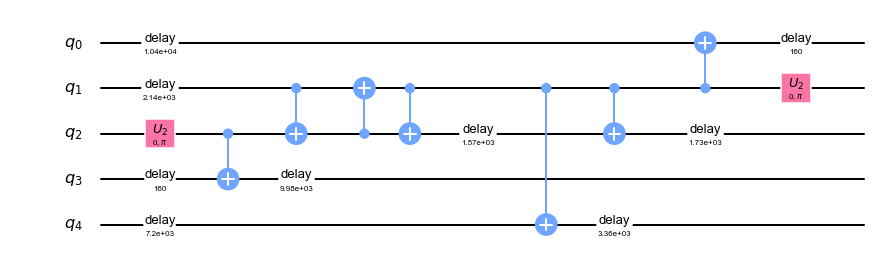

In [6]:
from qiskit.test.mock.backends import FakeParis

qc_scheduled = schedule(qc_transpiled, backend)
print(qc_scheduled.draw(fold=100))
qc_scheduled.draw('mpl')

## Relaxation noise insertion

Next we will use the scheduled circuit to insert relaxation noise on all instructions (including idle qubits). For this we need to get the T1 and T2 times for the backend, and the dt time unit to relate gate durations in the correct units

In [7]:
# Get dt, T1s and T2s from 
num_qubits = configuration.num_qubits
dt = configuration.dt
t1 = [properties.t1(i) for i in range(num_qubits)]
t2 = [properties.t2(i) for i in range(num_qubits)]

In [8]:
# Insert noise
qc_noise_scheduled = insert_noise(qc_scheduled, dt=dt, t1=t1, t2=t2)
qc_noise_scheduled.draw(fold=100)

┌──────────────┐                                                                          »
q_0: ┤ delay(noise) ├──────────────────────────────────────────────────────────────────────────»
     ├──────────────┤               ┌────────────┐ ┌────────────┐┌────────────┐                »
q_1: ┤ delay(noise) ├───────────────┤0           ├─┤1           ├┤0           ├────────────────»
     └┬───────────┬─┘┌────────────┐ │  cx(noise) │ │  cx(noise) ││  cx(noise) │┌──────────────┐»
q_2: ─┤ u2(noise) ├──┤0           ├─┤1           ├─┤0           ├┤1           ├┤ delay(noise) ├»
     ┌┴───────────┴─┐│  cx(noise) │┌┴────────────┴┐└────────────┘└────────────┘└──────────────┘»
q_3: ┤ delay(noise) ├┤1           ├┤ delay(noise) ├────────────────────────────────────────────»
     ├──────────────┤└────────────┘└──────────────┘                                            »
q_4: ┤ delay(noise) ├──────────────────────────────────────────────────────────────────────────»
     └──────────────┘                                                                          »
«                                    ┌────────────┐ ┌──────────────┐
«q_0: ───────────────────────────────┤1           ├─┤ delay(noise) ├
«     ┌────────────┐ ┌────────────┐  │  cx(noise) │ └┬───────────┬─┘
«q_1: ┤0           ├─┤0           ├──┤0           ├──┤ u2(noise) ├──
«     │            │ │  cx(noise) │ ┌┴────────────┴┐ └───────────┘  
«q_2: ┤            ├─┤1           ├─┤ delay(noise) ├────────────────
«     │  cx(noise) │ └────────────┘ └──────────────┘                
«q_3: ┤            ├────────────────────────────────────────────────
«     │            │┌──────────────┐                                
«q_4: ┤1           ├┤ delay(noise) ├────────────────────────────────
«     └────────────┘└──────────────┘

Note that how this function is implemented it returns a noisy implemention of the circuit by replacing each instruction with a Kraus operator for the noisy gate. This can then be executed on the Aer QasmSimulator, or using the `DensityMatrix` or `SuperOp` terra quantum info classes

### Circuit level error channel

We can look at the form of errors in the final circuit superoperator, and compute the average gate fidelity

In [9]:
op_noise = qi.SuperOp(qc_noise_scheduled)

In [10]:
qi.average_gate_fidelity(op_noise, op_ideal)

0.8760530026125949

We can also look at the operator of the error only term. Lets look at the Pauli-channel twirl of the error term. This is given by the diagonal of the Chi matrix representation

Text(0.5, 1.0, 'Error terms > 0.5%')

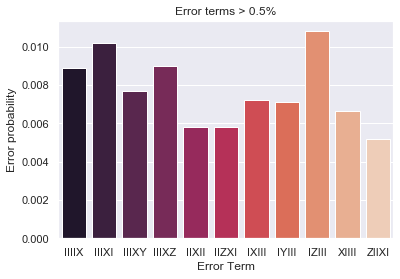

In [11]:
op_error = op_noise.dot(op_ideal.adjoint())
probs = qi.Chi(op_error).data.diagonal().real / (2 ** 5)
p_no_error = probs[0]
p_errors = probs[1:]

all_labels = list(it.product(['I', 'X', 'Y', 'Z'], repeat=5))[1:]

threshold = 5e-3
labels = [''.join(all_labels[i]) for i in range(len(p_errors)) if p_errors[i] > threshold]
paulis = [p_errors[i] for i in range(len(p_errors)) if p_errors[i] > threshold]
ax = sns.barplot(labels, paulis, palette='rocket')
ax.set_ylabel('Error probability')
ax.set_xlabel('Error Term')
ax.set_title('Error terms > 0.5%')

## Cross talk and relaxation noise insertion

Now we will also insert cross talk based on a simple ZZ coupling model

### Scheduling with time-steps

These align instructions by layers of the longest gate so multiqubit noise like cross-talk can be inserted in the correct locations. Note that this type of scheduling may insert *additional* delay compared to scheduling without time-steps if your gates don't all align on a grid

In [12]:
qc_ts_scheduled = timestep_schedule(qc_transpiled, backend)
print(qc_ts_scheduled.draw(fold=100))

     |----------------------------------------------------------------------------------------------
q_0: | DELAY(160)[160] | TIMESTEP(160)[0] | DELAY(1984)[1984] | TIMESTEP(1984)[0] | DELAY(1632)[1632
q_1: | DELAY(160)[160] | TIMESTEP(160)[0] | DELAY(1984)[1984] | TIMESTEP(1984)[0] |   CX(1,2)[1632] 
q_2: |  U2(0,pi)[160]  | TIMESTEP(160)[0] |   CX(2,3)[1984]   | TIMESTEP(1984)[0] |   CX(1,2)[1632] 
q_3: | DELAY(160)[160] | TIMESTEP(160)[0] |   CX(2,3)[1984]   | TIMESTEP(1984)[0] | DELAY(1632)[1632
q_4: | DELAY(160)[160] | TIMESTEP(160)[0] | DELAY(1984)[1984] | TIMESTEP(1984)[0] | DELAY(1632)[1632
     |----------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
] | TIMESTEP(1632)[0] | DELAY(1792)[1792] | TIMESTEP(1792)[0] | DELAY(1632)[1632] | TIMESTEP(1632)[0
  | TIMESTEP(1632)[0] |   CX(2,1)[1792]   | TIMESTEP(1792)[0] |   CX(1,2)[1632]   | TIMESTE

### Inserting Noise

Now we insert the cross talk and relaxation noise

In [13]:
w_zz = 2 * np.pi * 50e3  # 50 KHz
zz_map = [(w_zz, q) for q in np.unique(np.sort(coupling_map), axis=0).tolist()]
zz_map

[(314159.2653589793, [0, 1]),
 (314159.2653589793, [1, 2]),
 (314159.2653589793, [1, 4]),
 (314159.2653589793, [2, 3])]

In [14]:
# Insert noise
qc_noise_ts_scheduled = insert_noise(qc_ts_scheduled, dt=dt, t1=t1, t2=t2, zz_map=zz_map)
qc_noise_ts_scheduled.draw(fold=100)

┌──────────────┐┌────────────┐┌──────────────┐                              ┌────────────┐»
q_0: ┤ delay(noise) ├┤0           ├┤ delay(noise) ├──────────────────────────────┤0           ├»
     ├──────────────┤│  ZZ(noise) │└┬────────────┬┘┌────────────┐┌──────────────┐│  ZZ(noise) │»
q_1: ┤ delay(noise) ├┤1           ├─┤0           ├─┤0           ├┤ delay(noise) ├┤1           ├»
     └┬───────────┬─┘└────────────┘ │  ZZ(noise) │ │            │└┬────────────┬┘├────────────┤»
q_2: ─┤ u2(noise) ├─────────────────┤1           ├─┤            ├─┤0           ├─┤0           ├»
     ┌┴───────────┴─┐               └────────────┘ │  ZZ(noise) │ │  ZZ(noise) │ │  cx(noise) │»
q_3: ┤ delay(noise) ├──────────────────────────────┤            ├─┤1           ├─┤1           ├»
     ├──────────────┤                              │            │┌┴────────────┴┐└────────────┘»
q_4: ┤ delay(noise) ├──────────────────────────────┤1           ├┤ delay(noise) ├──────────────»
     └──────────────┘                              └────────────┘└──────────────┘              »
«     ┌──────────────┐                                              ┌────────────┐┌──────────────┐»
«q_0: ┤ delay(noise) ├──────────────────────────────────────────────┤0           ├┤ delay(noise) ├»
«     └┬────────────┬┘┌────────────┐                 ┌────────────┐ │  ZZ(noise) │└┬────────────┬┘»
«q_1: ─┤0           ├─┤0           ├─────────────────┤0           ├─┤1           ├─┤0           ├─»
«      │  ZZ(noise) │ │            │ ┌────────────┐  │  cx(noise) │ └────────────┘ │  ZZ(noise) │ »
«q_2: ─┤1           ├─┤            ├─┤0           ├──┤1           ├────────────────┤1           ├─»
«      └────────────┘ │  ZZ(noise) │ │  ZZ(noise) │ ┌┴────────────┴┐               └────────────┘ »
«q_3: ────────────────┤            ├─┤1           ├─┤ delay(noise) ├──────────────────────────────»
«                     │            │┌┴────────────┴┐└──────────────┘                              »
«q_4: ────────────────┤1           ├┤ delay(noise) ├──────────────────────────────────────────────»
«                     └────────────┘└──────────────┘                                              »
«                                                   ┌────────────┐┌──────────────┐              »
«q_0: ──────────────────────────────────────────────┤0           ├┤ delay(noise) ├──────────────»
«     ┌────────────┐                 ┌────────────┐ │  ZZ(noise) │└┬────────────┬┘┌────────────┐»
«q_1: ┤0           ├─────────────────┤1           ├─┤1           ├─┤0           ├─┤0           ├»
«     │            │ ┌────────────┐  │  cx(noise) │ └────────────┘ │  ZZ(noise) │ │            │»
«q_2: ┤            ├─┤0           ├──┤0           ├────────────────┤1           ├─┤            ├»
«     │  ZZ(noise) │ │  ZZ(noise) │ ┌┴────────────┴┐               └────────────┘ │  ZZ(noise) │»
«q_3: ┤            ├─┤1           ├─┤ delay(noise) ├──────────────────────────────┤            ├»
«     │            │┌┴────────────┴┐└──────────────┘                              │            │»
«q_4: ┤1           ├┤ delay(noise) ├──────────────────────────────────────────────┤1           ├»
«     └────────────┘└──────────────┘                                              └────────────┘»
«                                     ┌────────────┐┌──────────────┐                            »
«q_0: ────────────────────────────────┤0           ├┤ delay(noise) ├────────────────────────────»
«                      ┌────────────┐ │  ZZ(noise) │└┬────────────┬┘┌────────────┐              »
«q_1: ─────────────────┤0           ├─┤1           ├─┤0           ├─┤0           ├──────────────»
«      ┌────────────┐  │  cx(noise) │ └────────────┘ │  ZZ(noise) │ │            │┌────────────┐»
«q_2: ─┤0           ├──┤1           ├────────────────┤1           ├─┤            ├┤0           ├»
«      │  ZZ(noise) │ ┌┴────────────┴┐               └────────────┘ │  ZZ(noise) ││  ZZ(noise) │»
«q_3: ─┤1           ├─┤ delay(noise) ├──────────────────────────────┤     

### Circuit level error channel

We can look at the form of errors in the final circuit superoperator, and compute the average gate fidelity

In [25]:
op_noise_ts = qi.SuperOp(qc_noise_ts_scheduled)

In [26]:
qi.average_gate_fidelity(op_noise_ts, op_ideal)

0.6770164352353518

We can also look at the operator of the error only term. Lets look at the Pauli-channel twirl of the error term. This is given by the diagonal of the Chi matrix representation

Text(0.5, 1.0, '50 KHz Cross-talk, error terms > 0.5%')

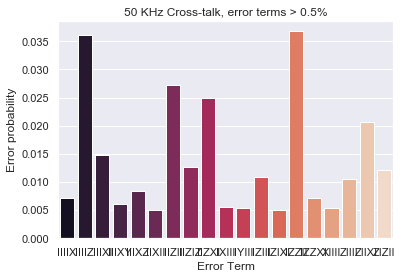

In [27]:
op_error_ts = op_noise_ts.dot(op_ideal.adjoint())
probs_ts = qi.Chi(op_error_ts).data.diagonal().real / (2 ** 5)
p_no_error_ts = probs_ts[0]
p_errors_ts = probs_ts[1:]

threshold = 5e-3

labels_ts = [''.join(all_labels[i]) for i in range(len(p_errors_ts)) if p_errors_ts[i] > threshold]
paulis_ts = [p_errors_ts[i] for i in range(len(p_errors_ts)) if p_errors_ts[i] > threshold]
ax = sns.barplot(labels_ts, paulis_ts, palette='rocket')
ax.set_ylabel('Error probability')
ax.set_xlabel('Error Term')
ax.set_title('50 KHz Cross-talk, error terms > 0.5%')

## Generate data as function of cross-talk

In [28]:
w_zzs = [2e3 * np.pi * f for f in [10, 50, 100, 200]]
noise_circs = []

for w_zz in w_zzs:
    zz_map = [(w_zz, q) for q in np.unique(np.sort(coupling_map), axis=0).tolist()]
    noise_circs.append(insert_noise(qc_ts_scheduled, dt=dt, t1=t1, t2=t2, zz_map=zz_map))

In [29]:
error_ops = [qi.SuperOp(circ).dot(op_ideal.adjoint()) for circ in noise_circs]
fids = [qi.average_gate_fidelity(op) for op in error_ops]

noise_probs = [(qi.Chi(op).data.diagonal().real / (2 ** 5))[1:] for op in error_ops]

In [30]:
threshold = 1e-2
noise_labels = []
noise_ps = []
for probs in noise_probs:
    size = len(probs)
    noise_labels.append([''.join(all_labels[i]) for i in range(size) if probs[i] > threshold])
    noise_ps.append([probs[i] for i in range(size) if probs[i] > threshold])

F_ave = 0.867


Text(0.5, 1.0, '10 KHz Cross-talk, error terms > 1%')

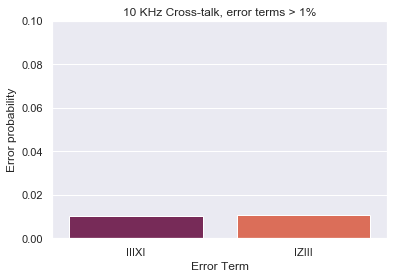

In [32]:
print('F_ave =', round(fids[0], 3))

ax1 = sns.barplot(noise_labels[0], noise_ps[0], palette='rocket')
ax1.set(ylim=(0, 0.1))
ax1.set_ylabel('Error probability')
ax1.set_xlabel('Error Term')
ax1.set_title('10 KHz Cross-talk, error terms > 1%')

F_ave = 0.677


Text(0.5, 1.0, '50 KHz Cross-talk, error terms > 1%')

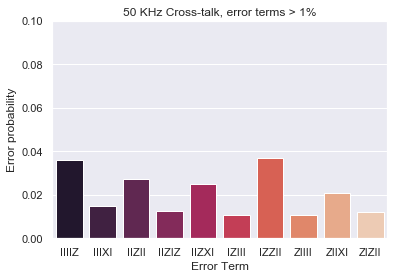

In [33]:
print('F_ave =', round(fids[1], 3))

ax2 = sns.barplot(noise_labels[1], noise_ps[1], palette='rocket')
ax2.set(ylim=(0, 0.1))
ax2.set_ylabel('Error probability')
ax2.set_xlabel('Error Term')
ax2.set_title('50 KHz Cross-talk, error terms > 1%')

F_ave = 0.364


Text(0.5, 1.0, '100 KHz Cross-talk, error terms > 1%')

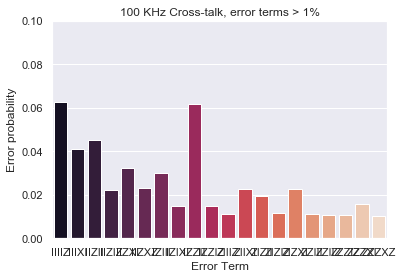

In [34]:
print('F_ave =', round(fids[2], 3))

ax3 = sns.barplot(noise_labels[2], noise_ps[2], palette='rocket')
ax3.set(ylim=(0, 0.1))
ax3.set_ylabel('Error probability')
ax3.set_xlabel('Error Term')
ax3.set_title('100 KHz Cross-talk, error terms > 1%')

F_ave = 0.089


Text(0.5, 1.0, '200 KHz Cross-talk, error terms > 1%')

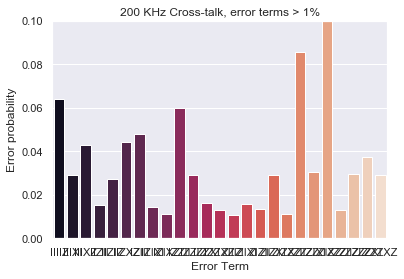

In [35]:
print('F_ave =', round(fids[3], 3))

ax4 = sns.barplot(noise_labels[3], noise_ps[3], palette='rocket')
ax4.set(ylim=(0, 0.1))
ax4.set_ylabel('Error probability')
ax4.set_xlabel('Error Term')
ax4.set_title('200 KHz Cross-talk, error terms > 1%')